In [69]:
import numpy as np
import pandas as pd
import csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import random
import time
import matplotlib.pyplot as plt 

In [2]:
myname = "Ritesh-Gupta-"
features = []
for k in range(58):
    features.append(str(k))

In [3]:
f = open('dataset/spam_data.txt', 'r')
data = []
for line in f.readlines():
    r = []
    for word in line.split():
        r.append(word)
    data.append(r)
f.close()
data = np.asarray(data)
data = data.astype(float)

In [4]:
length = len(data)
np.random.shuffle(data)
train_data = data[:int(0.7*length),:]
test_data = data[int(0.7*length):,:]
print(train_data.shape)

(3220, 58)


In [5]:
X_tra = train_data[:,:-1]
y_tra = train_data[:,-1]
X_test = test_data[:,:-1]
y_test = test_data[:,57]
print(X_test.shape)
np.sum(y_test)

(1381, 57)


561.0

In [6]:
y_test

array([0., 1., 1., ..., 1., 1., 1.])

# Finding Unique Element and its count

In [14]:
def unique_count_dict(col):
    unique_elements, counts_elements = np.unique(col, return_counts=True)
    return dict(zip(unique_elements,counts_elements))

# Entropy function e = sum(-p*log2(p))

In [15]:
def entropy(p):
    return -np.sum(np.multiply(p,np.log2(p)))

In [16]:
def impurity(rows):
    count=unique_count_dict(rows[:,-1])
    p = []
    for label in count:
        p.append(count[label]/float(len(rows)))
    #return gini(p)
    return entropy(p)

# Gini Impurity g = 1- sum(pi^2)

In [17]:
def gini(prob):
    impurity=1
    return (1 - np.sum(np.power(prob,2)))

# Information Gain of a column

In [18]:
def info_gain_entropy(current,left,right):
    p =float(len(left))/len(left)+len(right)
    left = np.asarray(left)
    right = np.asarray(right)
    return current-p*impurity(left)-(1-p)*impurity(right)

# Finding Question

In [19]:
class Question:
    def __init__(self,column,value):
        self.column=column
        self.value=value
    def match(self,data):
        value=data[self.column]
        #print(self.column)
        return value>=self.value
    def __repr__(self):
        condition = ">="
        return "Is %s %s %s?" % (features[self.column], condition, str(self.value))

# Partition column based of question

In [20]:
def split(data,val,col):
    true_row,false_row=[],[]
    for row in data:
        if row[col] >= val:
            true_row.append(row)
        else:
            false_row.append(row)
    true_row  = np.asarray(true_row)
    false_row = np.asarray(false_row) 
    return true_row,false_row

# Calculate best gain and Split of dataset

In [21]:
def best_split(rows,feature_list):
    best_gain=0
    best_question=None
    value = 0
    column = 0
    current=impurity(rows)
    for col in feature_list:
        val = np.average(rows[:,col])
        question = Question(col,val)
        true_rows,false_rows = split(rows,val,col)
        if len(true_rows) == 0 or len(false_rows) == 0:
            continue
        gain=info_gain_entropy(current,true_rows,false_rows)
        if gain>=best_gain:
                best_gain,best_question,value,column=gain,question,val,col
    return best_gain,best_question,value,column

# Class to store decision Node i.e. question of split left and right branch

In [22]:
class DecisionNode:
    def __init__(self,question,true_branch,false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

# Storing Leaf instance with % of occurence of label

In [23]:
class Leaf:
    def __init__(self,rows):
        count = unique_count_dict(rows[:,-1])
        p = {}
        for label in count:
            p[label] = count[label]/float(len(rows))
        self.dict = p

# Building tree recursively

In [24]:
def build_tree(rows, feature_list):
    gain,ques,val,col=best_split(rows, feature_list)
    if gain==0:
        return Leaf(rows)
    true_rows, false_rows = split(rows,val,col)
    true_branch = build_tree(true_rows,feature_list)
    false_branch = build_tree(false_rows,feature_list)
    return DecisionNode(ques,true_branch, false_branch)

# Classify the predicted Node

In [25]:
def classify(row, node):
    if isinstance(node, Leaf):
        #print(node,Leaf)
        return node.dict
    if node.question.match(row):
        #print(node.question.match(row))
        return classify(row, node.true_branch)
    else:
        #print(node.question.match(row))
        return classify(row, node.false_branch)

# Function to calculate accuracy

In [54]:
def accuracy(result,c):
    pred_label = []
    val = 0
    count = 0
    for i in range(len(c)):
        if c[i] == result[i]:
            count +=1
    return (count/len(c)*100)

# Parse the dictionary of leaf

In [27]:
def parseDict(p):
    max1 = 0
    max2 = 0
    if len(p) == 2: 
        for k,v in p.items():
            #max1 = int(v.replace("%",""))
            max1 = int(v)
            d = k
            if max1 > max2:
                d = k
    else:
        for k,v in p.items():
            d = k
    return d

# Test the accuracy

In [55]:
def test(total_tree,X_test,y_test):
    pred = []
    for i in range(len(X_test)):
        res = []
        for j in range(len(total_tree)):
            p = classify(X_test[i], total_tree[j])
            res.append(parseDict(p))
        res = np.asarray(res)
        count1 = np.sum(res)
        count0 = len(total_tree) - count1
        if count1 > count0:
            pred.append(1.0)
        else:
            pred.append(0.0)
    pred = np.asarray(pred)
    return accuracy(pred,y_test)

In [ ]:
# Random FOrest creation.

In [29]:
def randomforest(m):
    total_feature = train_data.shape[1]-1
    no_of_itr = 10
    acc = []
    pred = []
    total_tree = []
    for itr in range(no_of_itr):
        rand = np.arange(total_feature)
        rand = list(rand)
        feature_list = random.sample(rand, k=m)
        print('Done with Iteration', itr)
        features_to_train = m
        sample = 2000
        X_tr = train_data[:sample,:]
        #build the tree
        tree = build_tree(X_tr,feature_list)
        total_tree.append(tree)
    return total_tree

# Creating Trees and Testing the accuracy of RF.

In [71]:
start = time.time()
print(test(randomforest(40),X_test,y_test))
end = time.time()
print(end-start)

Done with Iteration 0
Done with Iteration 1
Done with Iteration 2
Done with Iteration 3
Done with Iteration 4
Done with Iteration 5
Done with Iteration 6
Done with Iteration 7
Done with Iteration 8
Done with Iteration 9
88.41419261404779
145.24970197677612


# Classify with Scikit-Learn Random Forest

In [66]:
start = time.time()
clf=RandomForestClassifier()
clf.fit(X_tra, y_tra)
pred = clf.predict(X_test)
print("Accuracy", accuracy(pred,y_test))
end= time.time()
print("Time of Scikit-learn RF ",end-start)

/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy 94.6415640839971
Time of Scikit-learn RF  0.23510098457336426


# Test with different m Scikit-learn

In [40]:
time_scikit = []
scikit_res = []
for i in range(2,56,2):
    start = time.time()
    clf=RandomForestClassifier(max_features=i)
    clf.fit(X_tra, y_tra)
    pred = clf.predict(X_test)
    scikit_res.append(accuracy(pred,y_test))
    end = time.time()
    time_scikit.append(end-start)

/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381
1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381
1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381
1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


/home/ritesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1381 1381


In [67]:
print("Accuracy and correspoding time" )
print(scikit_res)
print(time_scikit)

Accuracy and correspoding time
[94.78638667632151, 94.5691527878349, 94.93120926864592, 94.93120926864592, 94.6415640839971, 94.4967414916727, 93.9898624185373, 94.93120926864592, 94.27950760318609, 94.42433019551049, 94.71397538015931, 94.0622737146995, 94.85879797248371, 93.77262853005068, 94.5691527878349, 93.70021723388848, 94.0622737146995, 94.1346850108617, 94.78638667632151, 93.9174511223751, 93.84503982621288, 94.0622737146995, 94.2070963070239, 93.62780593772628, 94.27950760318609, 94.27950760318609, 93.84503982621288]
[0.10441756248474121, 0.11977410316467285, 0.25308942794799805, 0.23965024948120117, 0.19242072105407715, 0.25943446159362793, 0.16741514205932617, 0.21993446350097656, 0.2600259780883789, 0.3288261890411377, 0.29448628425598145, 0.3636331558227539, 0.39135289192199707, 0.7147488594055176, 0.7983500957489014, 0.6704025268554688, 0.5952112674713135, 0.58144211769104, 0.9007954597473145, 0.6976778507232666, 0.5864591598510742, 0.6420249938964844, 0.751427888870239

# Sensitivity Plot

In [42]:
final_res = []
time_RF = []
for m in range(2,56,2):
    start = time.time()
    final_res.append(test(randomforest(m),X_test,y_test))
    end = time.time()
    time_RF.append(end-start)

Done with Iteration 0
Done with Iteration 1
Done with Iteration 2
Done with Iteration 3
Done with Iteration 4
Done with Iteration 5
Done with Iteration 6
Done with Iteration 7
Done with Iteration 8
Done with Iteration 9
1381 1381
Done with Iteration 0
Done with Iteration 1
Done with Iteration 2
Done with Iteration 3
Done with Iteration 4
Done with Iteration 5
Done with Iteration 6
Done with Iteration 7
Done with Iteration 8
Done with Iteration 9
1381 1381
Done with Iteration 0
Done with Iteration 1
Done with Iteration 2
Done with Iteration 3
Done with Iteration 4
Done with Iteration 5
Done with Iteration 6
Done with Iteration 7
Done with Iteration 8
Done with Iteration 9
1381 1381
Done with Iteration 0
Done with Iteration 1
Done with Iteration 2
Done with Iteration 3
Done with Iteration 4
Done with Iteration 5
Done with Iteration 6
Done with Iteration 7
Done with Iteration 8
Done with Iteration 9
1381 1381
Done with Iteration 0
Done with Iteration 1
Done with Iteration 2
Done with Iter

In [68]:
print("Sensitivity Accuracies with different m",final_res)

Sensitivity Accuracies with different m [40.62273714699493, 45.54670528602462, 46.99493120926865, 50.832729905865314, 59.015206372194065, 62.99782766111514, 64.66328747284577, 65.17016654598117, 71.61477190441708, 74.65604634322955, 77.4076755973932, 82.76611151339608, 77.5524981897176, 80.37653874004344, 82.40405503258509, 82.76611151339608, 82.6212889210717, 82.83852280955828, 86.38667632150614, 87.47284576393918, 87.03837798696597, 89.57277335264301, 88.6314265025344, 89.2831281679942, 89.86241853729182, 89.210716871832, 89.210716871832]


# Plotting Graph of sensitivity

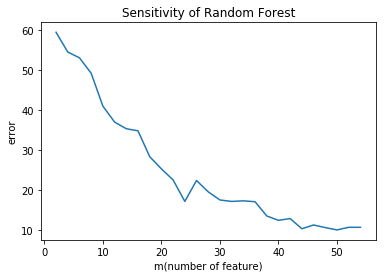

In [44]:

x = []
for m in range(2,56,2):
    x.append(m)
training_errors = []
for i in range(len(final_res)):
    training_errors.append(100-final_res[i])
plt.plot(x, training_errors) 
  
plt.xlabel('m(number of feature)') 
plt.ylabel('error') 
  
# giving a title to my graph 
plt.title('Sensitivity of Random Forest') 
  
# function to show the plot 
plt.show()

# Compare with Scikit learn and Scratch RF

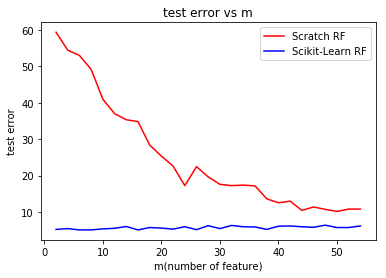

In [50]:
import matplotlib.pyplot as plt 
x = []
for m in range(2,56,2):
    x.append(m)
test_errors = []
scikit_test_error = []
for i in range(len(final_res)):
    test_errors.append(100-final_res[i])
    scikit_test_error.append(100-scikit_res[i])
plt.plot(x, test_errors,color = 'r',label = 'Scratch RF')
plt.plot(x, scikit_test_error,color = 'b',label = 'Scikit-Learn RF')
  
plt.xlabel('m(number of feature)') 
plt.ylabel('test error') 
  
# giving a title to my graph 
plt.title('test error vs m') 
plt.legend(['Scratch RF', 'Scikit-Learn RF'], loc='upper right')  
# function to show the plot 
plt.show()

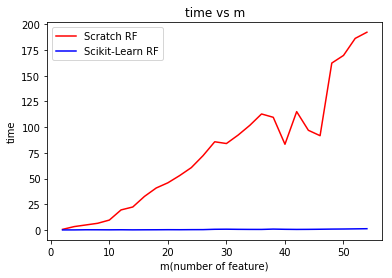

In [52]:
x = []
for m in range(2,56,2):
    x.append(m)
plt.plot(x, time_RF,color = 'r',label = 'Scratch RF')
plt.plot(x, time_scikit,color = 'b',label = 'Scikit-Learn RF')
  
plt.xlabel('m(number of feature)') 
plt.ylabel('time') 
  
# giving a title to my graph 
plt.title('time vs m') 
plt.legend(['Scratch RF', 'Scikit-Learn RF'], loc='upper left')  
# function to show the plot 
plt.show()

# OOB Error

In [60]:
def randomforestOOB(m):
    total_feature = train_data.shape[1]-1
    no_of_itr = 10
    acc = []
    pred = []
    total_tree = []
    for itr in range(no_of_itr):
        rand = np.arange(total_feature)
        rand = list(rand)
        feature_list = random.sample(rand, k=m)
        print('features', itr)
        #features_to_train = m
        sample = 2000
        X_tr = train_data[:sample,:]
        #build the tree
        tree = build_tree(X_tr,feature_list)
        total_tree.append(tree)
    return total_tree

In [61]:
final_res_OOB = []
X_test_OOB = train_data[2000:,:-1]
y_test_OOB = train_data[2000:,-1]
for m in range(2,56,2):
    final_res_OOB.append(test(randomforestOOB(m),X_test_OOB,y_test_OOB))


features 0
features 1
features 2
features 3
features 4
features 5
features 6
features 7
features 8
features 9
features 0
features 1
features 2
features 3
features 4
features 5
features 6
features 7
features 8
features 9
features 0
features 1
features 2
features 3
features 4
features 5
features 6
features 7
features 8
features 9
features 0
features 1
features 2
features 3
features 4
features 5
features 6
features 7
features 8
features 9
features 0
features 1
features 2
features 3
features 4
features 5
features 6
features 7
features 8
features 9
features 0
features 1
features 2
features 3
features 4
features 5
features 6
features 7
features 8
features 9
features 0
features 1
features 2
features 3
features 4
features 5
features 6
features 7
features 8
features 9
features 0
features 1
features 2
features 3
features 4
features 5
features 6
features 7
features 8
features 9
features 0
features 1
features 2
features 3
features 4
features 5
features 6
features 7
features 8
features 9
features 0

In [62]:
print(final_res_OOB)

[40.32786885245901, 41.80327868852459, 47.459016393442624, 53.11475409836065, 57.950819672131146, 57.786885245901644, 64.67213114754098, 68.60655737704919, 69.50819672131148, 75.98360655737704, 76.88524590163934, 80.73770491803278, 81.63934426229508, 82.70491803278689, 85.08196721311475, 85.1639344262295, 84.67213114754098, 84.67213114754098, 87.1311475409836, 86.88524590163934, 87.95081967213115, 88.11475409836066, 88.03278688524591, 88.36065573770492, 88.52459016393442, 88.60655737704917, 88.60655737704917]


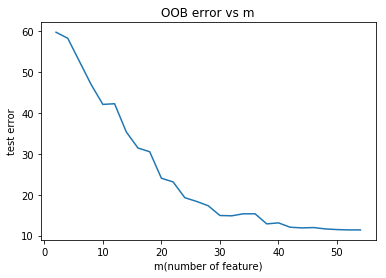

In [64]:
x_OOB = []
for m in range(2,56,2):
    x_OOB.append(m)
test_errors = []
for i in range(len(final_res)):
    test_errors.append(100-final_res_OOB[i])
plt.plot(x, test_errors) 
  
plt.xlabel('m(number of feature)') 
plt.ylabel('test error') 
  
# giving a title to my graph 
plt.title('OOB error vs m') 
  
# function to show the plot 
plt.show()